In [38]:
import sys
import xarray as xr
import numpy as np
import Plotter
from Plotter import Plotter
import time
from preprocessing_utils_sampling import *
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn import metrics
import pyxpcm
from pyxpcm.models import pcm
import warnings
import glob
import seaborn as sns
from joblib import dump, load

from joblib import Parallel, delayed
import multiprocessing

warnings.filterwarnings('ignore')

In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
def train_model(k, x, algo):
    if algo == "kmean":
        print("model used: kmean")
        model = sklearn.cluster.KMeans(n_clusters=k, n_init=10, max_iter=1000)
    elif algo == "batch":
        print("model used: mini batch kmean")
        model = sklearn.cluster.MiniBatchKMeans(n_clusters=k, n_init=10, max_iter=1000, batch_size=100)
    else:
        print("model used: GMM")
        model = sklearn.mixture.GaussianMixture(n_components=k, max_iter=1000, tol=1e-6)
    model.fit(x)
    return model

In [4]:
def score_model(m, m_full, x):
    pred = m.predict(x)
    truth = m_full.predict(x)
    print("sample")
    print(f"model score (higher is best): {m.score(x)}")
#     print(f"silhouette score (closer to 1 is best): {metrics.silhouette_score(x, pred)}")
    print("---------------------------------------------------")
    print("full")
    print(f"model score (higher is best): {m_full.score(x)}")
#     print(f"silhouette score (closer to 1 is best): {metrics.silhouette_score(x, truth)}")
    print("---------------------------------------------------")
    print(f" adjusted rand score: {metrics.adjusted_rand_score(truth, pred)}")
    print(f" unadjusted rand score: {metrics.rand_score(truth, pred)}")
    print("---------------------------------------------------")
    print(f" adjusted mutual info score: {metrics.adjusted_mutual_info_score(truth, pred)}")
    print(f" unadjusted mutual info score: {metrics.mutual_info_score(truth, pred)}")

#     print(f"model score: {m.score(x)}")
#     print(f"model score: {m.score(x)}")

In [5]:
def score_iter(m, m_full, x):
    pred = m.predict(x)
    truth = m_full.predict(x)
    return m.score(x), metrics.rand_score(truth, pred), metrics.mutual_info_score(truth, pred)

In [63]:
def predict(x, m, var_name_ds, k, var_predict):
    classif = m.predict(x[var_predict])
    x = x.assign(variables={"labels": ('sample_dim', classif)})
    q = [0.05, 0.5, 0.95]
    x = compute_quantile(x, var_name_ds, k, q)
    x = x.assign_coords(coords={'k': range(k)})
    x = x.unstack('sample_dim')
    return x

In [7]:
def generate_plots(ds, var_name_ds, k, algorithm):
    """
    Generates and saves the following plots:
    - vertical structure: vertical structure of each classes. It draws the mean profile and the 0.05 and 0.95 quantiles
    - vertical structure comp: vertical structure graph but Quantiles are being plotted together to highlight
    differences between classes.
    - Spacial distribution: plot the PCM labels in a map to analyse the spatial coherence of classes.
    - Robustness: spacial distribution of a scaled probability of a profile to belong to a class.
    - Pie chart: pie chart showing the percentage of profiles belonging to each class and the number of
    classified profiles.
    - Temporal distribution by month: The bar plots represents the percentage of profiles in each class by month.
    - Temporal distribution by season: The bar plots represents the percentage of profiles in each class by season.
    Parameters
    ----------
    ds : Xarray dataset containing the predictions
    var_name_ds : name of the variable in the dataset

    Returns
    -------
    saves all the plots as png
    """
    try:
        x_label = ds[var_name_ds].attrs['long_name'] + " in " + ds[var_name_ds].attrs['unit_long']
    except KeyError:
        x_label = var_name_ds

    # create a pyXpcm model to use the Plotter class
    var_name_mdl = var_name_ds
    z_dim = 'depth'
    z = ds[z_dim]
    pcm_features = {var_name_mdl: z}
    m = pcm(K=k, features=pcm_features)
    ds = ds.rename({'labels': 'PCM_LABELS'})
    ds = ds.sortby('latitude').sortby('longitude')
    P = Plotter(ds, m, coords_dict={'latitude': 'latitude', 'longitude': 'longitude', 'time': 'time', 'depth': 'depth'})

    # plot profiles by class
    P.vertical_structure(q_variable=var_name_ds + '_Q', sharey=True, xlabel=x_label)
#     P.save_BlueCloud(f'./GMM_scaling_out/vertical_struc{algorithm}.png')
    # plot profiles by quantile
    P.vertical_structure_comp(q_variable=var_name_ds + '_Q', plot_q='all', xlabel=x_label)
#     P.save_BlueCloud(f'./GMM_scaling_out/vertical_struc_comp{algorithm}.png')
    # spacial distribution
#     P.spatial_distribution(time_slice='most_freq_label')
#     P.save_BlueCloud(f'./GMM_scaling_out/spatial_distr_freq{algorithm}.png')
    # robustness
    # P.plot_robustness(time_slice=first_date)
    # P.save_BlueCloud('robustness.png')
    # pie chart of the classes distribution
    P.pie_classes()
#     P.save_BlueCloud(f'./GMM_scaling_out/pie_chart{algorithm}.png')
    # temporal distribution (monthly)
    try:
        P.temporal_distribution(time_bins='month')
#         P.save_BlueCloud('temporal_distr_months.png')
    except (ValueError, AssertionError) as e:
#         save_empty_plot('temporal_distr_months')
        print('plot monthly temporal distribution is not available, the following error occurred:')
        print(e, file=sys.stderr)
    # temporal distribution (seasonally)
    try:
        P.temporal_distribution(time_bins='season')
#         P.save_BlueCloud('temporal_distr_season.png')
    except (ValueError, AssertionError) as e:
#         save_empty_plot('temporal_distr_season')
        print('plot seasonal temporal distribution is not available, the following error occurred:')
        print(e, file=sys.stderr)

# Execution of the code

## parameters

In [8]:
# var_name_ds = "TEMP"
var_name_ds = 'thetao'
var_name_mdl = "temperature"
# algorithm choice can be: "kmean" for classic sklarn kmean, "batch" for sklearn kmean mini-batch, "GMM" for sklearn GMM
algorithm = "GMM"
k = 6
# file_name = '../datasets/global-reanalysis-phy-001-030-monthly_big.nc'
# dir_path = '/home/ref-coriolis-public/copernicus/INSITU_GLO_TS_OA_REP_OBSERVATIONS_013_002_b/CORIOLIS-GLOBAL-CORA-OBS_FULL_TIME_SERIE/field/'
# file_list = glob.glob(f"{dir_path}2019/*TEMP.nc")
# file_list+=glob.glob(f"{dir_path}2018/*TEMP.nc")

dir_path = "../datasets/"
file_list = glob.glob(f"{dir_path}global-reanalysis-phy-001-030-monthly_big.nc")
print(len(file_list))

len(file_list)
# spacial_domain = {"lon":[-5, 42],
#                  "lat": [30, 46],
#                  "depth": 800}
spacial_domain = {"lon":[-80, 80],
                 "lat": [-80, 80],
                 "depth": 800}
spacial_domain

1


{'lon': [-80, 80], 'lat': [-80, 80], 'depth': 800}

## Load and preprocessing
see in file preprocessing utils for details

In [9]:
ds = read_dataset(file_list, multiple=True, backend='sk')
ds

size full DS: 1.303983673453331 Go


<xarray.Dataset>
Dimensions:    (depth: 30, latitude: 193, longitude: 565, time: 107)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 266.0 318.1 380.2
  * latitude   (latitude) float32 30.0 30.08 30.17 30.25 ... 45.83 45.92 46.0
  * time       (time) datetime64[ns] 2010-08-16T12:00:00 ... 2019-06-16
  * longitude  (longitude) float32 -5.0 -4.917 -4.833 -4.75 ... 41.83 41.92 42.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(107, 30, 193, 565), meta=np.ndarray>
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [10]:
ds = select_var(ds, var_name_ds, multiple=True, backend='sk', spacial_domain=spacial_domain)
ds

size after selection of variable: 1.303983673453331 Go


<xarray.Dataset>
Dimensions:    (depth: 30, latitude: 193, longitude: 565, time: 107)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 266.0 318.1 380.2
  * latitude   (latitude) float32 30.0 30.08 30.17 30.25 ... 45.83 45.92 46.0
  * time       (time) datetime64[ns] 2010-08-16T12:00:00 ... 2019-06-16
  * longitude  (longitude) float32 -5.0 -4.917 -4.833 -4.75 ... 41.83 41.92 42.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 nan nan ... nan nan
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [11]:
x = filter_profiles(ds)
x = reformat_depth(x)
x = x.transpose()
x, scaler = standard_scaling(x, backend='sk', var_name=var_name_ds)
x, pca = fit_pca(x=x, n_comp=15, var_name=var_name_ds + '_scaled', backend='sk')
x

<xarray.Dataset>
Dimensions:                (depth: 30, feature: 30, feature_reduced: 15, sample_dim: 3466693)
Coordinates:
  * depth                  (depth) float32 -0.494 -1.541 ... -318.1 -380.2
  * sample_dim             (sample_dim) MultiIndex
  - longitude              (sample_dim) float64 -5.0 -5.0 -5.0 ... 41.5 41.5
  - latitude               (sample_dim) float64 35.75 35.75 ... 41.83 41.83
  - time                   (sample_dim) datetime64[ns] 2010-08-16T12:00:00 .....
Dimensions without coordinates: feature, feature_reduced
Data variables:
    thetao                 (sample_dim, depth) float32 25.16 25.02 ... 8.815
    thetao_scaled          (sample_dim, feature) float32 1.066 1.055 ... -2.255
    thetao_scaled_reduced  (sample_dim, feature_reduced) float32 -2.758 ... -...
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [12]:
print(x.latitude.max())
print(x.latitude.min())
print(x.longitude.max())
print(x.longitude.min())

<xarray.DataArray 'latitude' ()>
array(46.)
<xarray.DataArray 'latitude' ()>
array(30.75)
<xarray.DataArray 'longitude' ()>
array(41.5)
<xarray.DataArray 'longitude' ()>
array(-5.)


In [13]:
dump(pca, 'pca.joblib') 
dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [14]:
sampling_ratio = 6
long_idx = np.random.choice(len(ds['longitude']), len(ds['longitude'])//sampling_ratio)
lat_idx = np.random.choice(len(ds['latitude']), len(ds['latitude'])//sampling_ratio)
time_idx = np.random.choice(len(ds['time']), len(ds['time'])//2)
lat_idx

array([179,   6, 180,  88, 123, 188,  74,  17,  34, 108,  71,  68,  93,
       121,  62, 154,  46, 174, 153,  34,  98, 136, 158, 186, 107,   5,
        78, 117, 107,  55,  30,   4])

In [15]:
%%time
# x_reduced = ds.isel(longitude=long_idx, latitude=lat_idx, time=time_idx)
x_reduced = ds.isel(time=time_idx)
x_reduced = x_reduced.coarsen(latitude=5, boundary="trim").mean().coarsen(longitude=5, boundary="trim").mean()
print(x_reduced.latitude.max())
print(x_reduced.latitude.min())
print(x_reduced.longitude.max())
print(x_reduced.longitude.min())
x_reduced

<xarray.DataArray 'latitude' ()>
array(45.58333588)
<xarray.DataArray 'latitude' ()>
array(30.16666603)
<xarray.DataArray 'longitude' ()>
array(41.83333588)
<xarray.DataArray 'longitude' ()>
array(-4.83333302)
CPU times: user 874 ms, sys: 854 ms, total: 1.73 s
Wall time: 1.75 s


<xarray.Dataset>
Dimensions:    (depth: 30, latitude: 38, longitude: 113, time: 53)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 266.0 318.1 380.2
  * latitude   (latitude) float32 30.17 30.58 31.0 31.42 ... 44.75 45.17 45.58
  * time       (time) datetime64[ns] 2018-10-16T12:00:00 ... 2018-09-16
  * longitude  (longitude) float32 -4.833 -4.417 -4.0 ... 41.0 41.42 41.83
Data variables:
    thetao     (time, depth, latitude, longitude) float32 nan nan ... nan nan

In [16]:
%%time
x_reduced = filter_profiles(x_reduced)
x_reduced = reformat_depth(x_reduced)
x_reduced = x_reduced.transpose()
x_reduced = apply_scaling(x_reduced, var_name=var_name_ds, scaler=scaler)
x_reduced = apply_pca(x=x_reduced, var_name=var_name_ds + '_scaled', pca=pca)
x_reduced

CPU times: user 85.3 ms, sys: 20.2 ms, total: 105 ms
Wall time: 57.7 ms


<xarray.Dataset>
Dimensions:                (depth: 30, feature: 30, feature_reduced: 15, sample_dim: 84429)
Coordinates:
  * depth                  (depth) float32 -0.494 -1.541 ... -318.1 -380.2
  * sample_dim             (sample_dim) MultiIndex
  - longitude              (sample_dim) float64 -4.833 -4.833 ... 41.42 41.42
  - latitude               (sample_dim) float64 35.58 35.58 ... 42.25 42.25
  - time                   (sample_dim) datetime64[ns] 2018-10-16T12:00:00 .....
Dimensions without coordinates: feature, feature_reduced
Data variables:
    thetao                 (sample_dim, depth) float32 20.98 20.94 ... 8.811
    thetao_scaled          (sample_dim, feature) float32 0.2185 ... -2.258
    thetao_scaled_reduced  (sample_dim, feature_reduced) float32 -1.961 ... 0...

## Training

In [17]:
var_train = var_name_ds + "_scaled_reduced"

In [20]:
%%time
m_full = train_model(k=k, x=x[var_train], algo=algorithm)
# m_full = load('model_full_10y.joblib')

model used: GMM
CPU times: user 45min 51s, sys: 24min 37s, total: 1h 10min 29s
Wall time: 15min 3s


In [21]:
dump(m_full, 'modelk6_full_10y.joblib') 

['modelk6_full_10y.joblib']

In [22]:
m_full.score(x[var_train])

20.165304411520065

## subsampling for training

In [49]:
%%time
def run_one_init():
    index_train = np.random.choice(len(x[var_train]), 10_000)
    m_reduced = sklearn.mixture.GaussianMixture(n_components=k, max_iter=1000, tol=1e-6, n_init=1)
    m_reduced.fit(x[var_train][index_train])
    score = m_reduced.score(x[var_train])
    return score

num_cores = multiprocessing.cpu_count()
score = Parallel(n_jobs=num_cores)(delayed(run_one_init)()for i in range(8))
score

In [57]:
%%time
score = -100
final_weights = []
for i in range(10):
    index_train = np.random.choice(len(x[var_train]), 10_000)
    m_i = sklearn.mixture.GaussianMixture(n_components=k, max_iter=1000, tol=1e-6, n_init=1)
    m_i.fit(x[var_train][index_train])
    score_i = m_i.score(x[var_train])
    if score_i>score:
        score = score_i
        final = m_i
        print(score)

final.score(x[var_train])

20.080923114813803
20.095937025002282
20.09822053211397
20.1062823822687
CPU times: user 3min 34s, sys: 3min 12s, total: 6min 47s
Wall time: 1min 15s


20.1062823822687

In [59]:
score_model(m=final, m_full=m_full, x=x[var_train])

sample
model score (higher is best): 20.1062823822687
---------------------------------------------------
full
model score (higher is best): 20.165304411520065
---------------------------------------------------
 adjusted rand score: -2.2157883194618297
 unadjusted rand score: 0.9733816511355602
---------------------------------------------------
 adjusted mutual info score: 0.9161304177298034
 unadjusted mutual info score: 1.5108265657064543


## Warm start
Incremental training

In [19]:
m = sklearn.mixture.GaussianMixture(n_components=k, warm_start=True, tol=1e-6)
rs = ShuffleSplit(n_splits=10, train_size=20000, test_size=20000, random_state=0)
nb_profiles = []
score = []
rand_score = []
mutual_info_score = []
training_start = time.time()
for iter_nb, split in enumerate(rs.split(x[var_train])):
    start_time = time.time()
    if iter_nb%1 == 0:
        print("interation number", iter_nb, "TRAIN:", len(split[0]), "TEST:", len(split[1]))
    m.fit(x[var_train][split[0]])
    score_i, rand_score_i, mutual_i = score_iter(m=m, m_full=m_full, x=x[var_train])
    score.append(score_i)
    rand_score.append(rand_score_i)
    mutual_info_score.append(mutual_i)
    nb_profiles.append((iter_nb+1)*10000)
    if iter_nb%1 == 0:
        print("iteration number", iter_nb, "finished in", time.time()-start_time, " s\n------------------------\n")
        
print("full training finished in", time.time()-training_start, "for ",  ((iter_nb+1)*10000), "profiles")

interation number 0 TRAIN: 20000 TEST: 20000
iteration number 0 finished in 23.133736610412598  s
------------------------

interation number 1 TRAIN: 20000 TEST: 20000
iteration number 1 finished in 20.721637725830078  s
------------------------

interation number 2 TRAIN: 20000 TEST: 20000
iteration number 2 finished in 21.121086835861206  s
------------------------

interation number 3 TRAIN: 20000 TEST: 20000
iteration number 3 finished in 21.596965551376343  s
------------------------

interation number 4 TRAIN: 20000 TEST: 20000
iteration number 4 finished in 21.29021954536438  s
------------------------

interation number 5 TRAIN: 20000 TEST: 20000
iteration number 5 finished in 19.513837099075317  s
------------------------

interation number 6 TRAIN: 20000 TEST: 20000
iteration number 6 finished in 19.89190673828125  s
------------------------

interation number 7 TRAIN: 20000 TEST: 20000
iteration number 7 finished in 20.682921886444092  s
------------------------

interation

In [20]:
score_model(m=m, m_full=m_full, x=x[var_train])

sample
model score (higher is best): 21.466086422947665
---------------------------------------------------
full
model score (higher is best): 21.51357100783702
---------------------------------------------------
 adjusted rand score: -1.473236821938214
 unadjusted rand score: 0.9897289206165092
---------------------------------------------------
 adjusted mutual info score: 0.9475357496814285
 unadjusted mutual info score: 1.9028585389767347


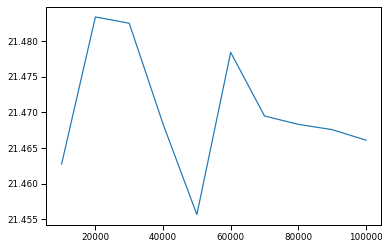

In [21]:
ax = sns.lineplot(x=nb_profiles, y=score)

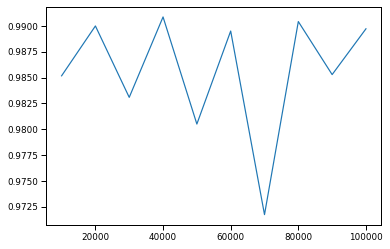

In [22]:
ax = sns.lineplot(x=nb_profiles, y=rand_score)

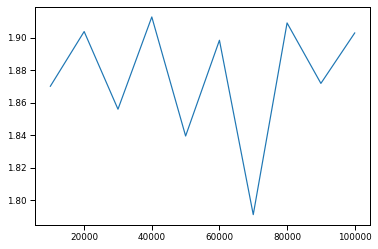

In [23]:
ax = sns.lineplot(x=nb_profiles, y=mutual_info_score)

## nb samples
increase number of samples

In [25]:
m = sklearn.mixture.GaussianMixture(n_components=k, n_init=1, tol=1e-6, max_iter=1000)
nb_profiles = []
score = []
rand_score = []
mutual_info_score = []
train_time = []
training_start = time.time()
for iter_nb, nb_profiles_i in enumerate([100, 500, 1_000, 5_000, 10_000, 25_000, 50_000, 75_000, 100_000, 200_000, 500_000]):
    if iter_nb%1 == 0:
        print("interation number", iter_nb, "TRAIN:", nb_profiles_i, "TEST: full", len(x[var_train]))
    index_train = np.random.choice(len(x[var_train]), nb_profiles_i)
    start_time = time.time()
    m.fit(x[var_train][index_train])
    train_time_i = time.time()-start_time
    score_i, rand_score_i, mutual_i = score_iter(m=m, m_full=m_full, x=x[var_train])
    score.append(score_i)
    rand_score.append(rand_score_i)
    mutual_info_score.append(mutual_i)
    train_time.append(train_time_i)
    nb_profiles.append(nb_profiles_i)
    if iter_nb%1 == 0:
        print("iteration number", iter_nb, "finished in", train_time_i, " s\n------------------------\n")

interation number 0 TRAIN: 100 TEST: full 3466693
iteration number 0 finished in 0.03102850914001465  s
------------------------

interation number 1 TRAIN: 500 TEST: full 3466693
iteration number 1 finished in 0.09132838249206543  s
------------------------

interation number 2 TRAIN: 1000 TEST: full 3466693
iteration number 2 finished in 0.4939100742340088  s
------------------------

interation number 3 TRAIN: 5000 TEST: full 3466693
iteration number 3 finished in 1.9748566150665283  s
------------------------

interation number 4 TRAIN: 10000 TEST: full 3466693
iteration number 4 finished in 4.2929627895355225  s
------------------------

interation number 5 TRAIN: 25000 TEST: full 3466693
iteration number 5 finished in 10.630676031112671  s
------------------------

interation number 6 TRAIN: 50000 TEST: full 3466693
iteration number 6 finished in 19.634331464767456  s
------------------------

interation number 7 TRAIN: 75000 TEST: full 3466693
iteration number 7 finished in 40.1

In [26]:
score_model(m=m, m_full=m_full, x=x[var_train])

sample
model score (higher is best): 21.509753427808967
---------------------------------------------------
full
model score (higher is best): 21.51357100783702
---------------------------------------------------
 adjusted rand score: 0.27567957182170394
 unadjusted rand score: 0.9964514016979823
---------------------------------------------------
 adjusted mutual info score: 0.9805021515769906
 unadjusted mutual info score: 1.967463208931818


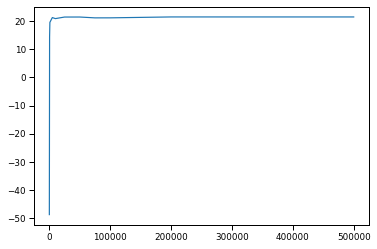

In [27]:
ax = sns.lineplot(x=nb_profiles, y=score)

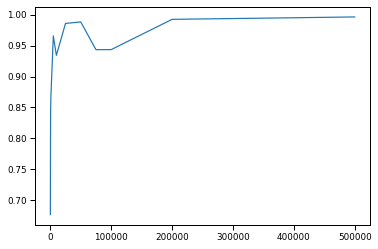

In [28]:
ax = sns.lineplot(x=nb_profiles, y=rand_score)

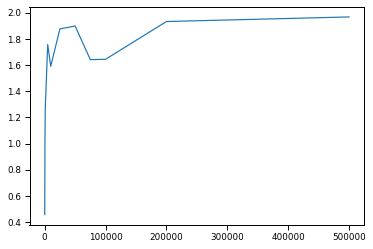

In [29]:
ax = sns.lineplot(x=nb_profiles, y=mutual_info_score)

In [51]:
m = sklearn.mixture.GaussianMixture(n_components=k, n_init=3, tol=1e-6, max_iter=1000)
nb_profiles = []
score = []
rand_score = []
mutual_info_score = []
training_start = time.time()
for iter_nb, nb_profiles_i in enumerate([100, 500, 1_000, 5_000, 10_000, 25_000, 50_000, 75_000, 100_000]):#, 200_000, 500_000]):
    if iter_nb%1 == 0:
        print("interation number", iter_nb, "TRAIN:", nb_profiles_i, "TEST: full", len(x[var_train]))
    index_train = np.random.choice(len(x[var_train]), nb_profiles_i)
    start_time = time.time()
    m.fit(x[var_train][index_train])
    train_time_i = time.time()-start_time
    score_i, rand_score_i, mutual_i = score_iter(m=m, m_full=m_full, x=x[var_train])
    score.append(score_i)
    rand_score.append(rand_score_i)
    mutual_info_score.append(mutual_i)
    train_time.append(train_time_i)
    nb_profiles.append(nb_profiles_i)
    if iter_nb%1 == 0:
        print("iteration number", iter_nb, "finished in", train_time_i, " s\n------------------------\n")

interation number 0 TRAIN: 100 TEST: full 3466693
iteration number 0 finished in 0.07394099235534668  s
------------------------

interation number 1 TRAIN: 500 TEST: full 3466693
iteration number 1 finished in 0.39420652389526367  s
------------------------

interation number 2 TRAIN: 1000 TEST: full 3466693
iteration number 2 finished in 0.9155917167663574  s
------------------------

interation number 3 TRAIN: 5000 TEST: full 3466693
iteration number 3 finished in 4.728519439697266  s
------------------------

interation number 4 TRAIN: 10000 TEST: full 3466693
iteration number 4 finished in 7.79852294921875  s
------------------------

interation number 5 TRAIN: 25000 TEST: full 3466693
iteration number 5 finished in 41.723602294921875  s
------------------------

interation number 6 TRAIN: 50000 TEST: full 3466693
iteration number 6 finished in 73.13901424407959  s
------------------------

interation number 7 TRAIN: 75000 TEST: full 3466693
iteration number 7 finished in 110.3726

In [52]:
score_model(m=m, m_full=m_full, x=x[var_train])

sample
model score (higher is best): 21.512037076903212
---------------------------------------------------
full
model score (higher is best): 21.51357100783702
---------------------------------------------------
 adjusted rand score: 1.169791580735099
 unadjusted rand score: 0.9904503751300908
---------------------------------------------------
 adjusted mutual info score: 0.9528614099172507
 unadjusted mutual info score: 1.9120716250033583


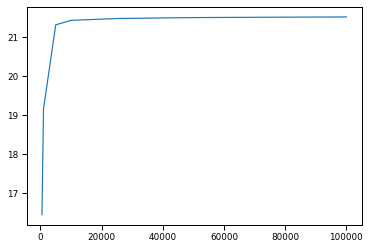

In [56]:
ax = sns.lineplot(x=nb_profiles[1:], y=score[1:])

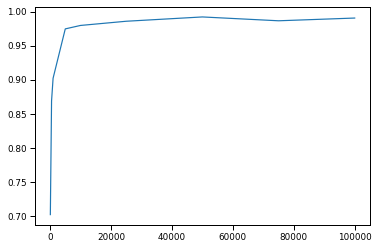

In [54]:
ax = sns.lineplot(x=nb_profiles, y=rand_score)

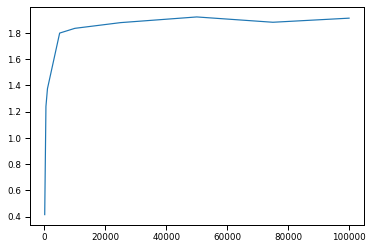

In [55]:
ax = sns.lineplot(x=nb_profiles, y=mutual_info_score)

## nb init
inrease nb init

In [46]:
nb_init = []
score = []
rand_score = []
mutual_info_score = []
train_time = []
index_train = np.random.choice(len(x[var_train]), 25_000)
training_start = time.time()
for iter_nb, nb_init_i in enumerate([1, 2, 3, 5, 7, 10]):#, 15, 20]):
    m = sklearn.mixture.GaussianMixture(n_components=k, n_init=nb_init_i, tol=1e-6, max_iter=1000)
    if iter_nb%1 == 0:
        print("interation number", iter_nb, "nb_init:", nb_init_i, "TEST: full", len(x[var_train]))
    start_time = time.time()
    m.fit(x[var_train][index_train])
    train_time_i = time.time()-start_time
    score_i, rand_score_i, mutual_i = score_iter(m=m, m_full=m_full, x=x[var_train])
    score.append(score_i)
    rand_score.append(rand_score_i)
    mutual_info_score.append(mutual_i)
    train_time.append(train_time_i)
    nb_init.append(nb_init_i)
    if iter_nb%1 == 0:
        print("iteration number", iter_nb, "finished in", train_time_i, " s\n------------------------\n")

interation number 0 nb_init: 1 TEST: full 3466693
iteration number 0 finished in 16.865015268325806  s
------------------------

interation number 1 nb_init: 2 TEST: full 3466693
iteration number 1 finished in 16.23478364944458  s
------------------------

interation number 2 nb_init: 3 TEST: full 3466693
iteration number 2 finished in 25.27818202972412  s
------------------------

interation number 3 nb_init: 5 TEST: full 3466693
iteration number 3 finished in 42.37070083618164  s
------------------------

interation number 4 nb_init: 7 TEST: full 3466693
iteration number 4 finished in 72.71938371658325  s
------------------------

interation number 5 nb_init: 10 TEST: full 3466693
iteration number 5 finished in 113.52223014831543  s
------------------------



In [47]:
score_model(m=m, m_full=m_full, x=x[var_train])

sample
model score (higher is best): 21.47361068970319
---------------------------------------------------
full
model score (higher is best): 21.51357100783702
---------------------------------------------------
 adjusted rand score: 2.4692427443960354
 unadjusted rand score: 0.9888190950852243
---------------------------------------------------
 adjusted mutual info score: 0.9441520636253814
 unadjusted mutual info score: 1.894115709333463


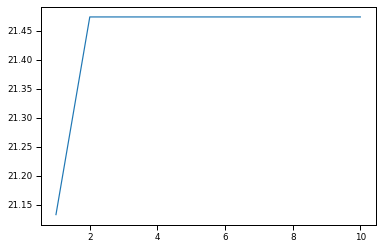

In [48]:
ax = sns.lineplot(x=nb_init, y=score)

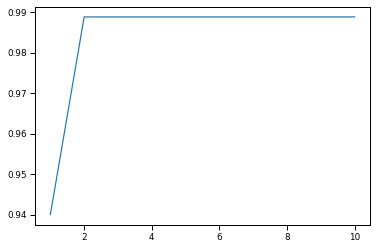

In [49]:
ax = sns.lineplot(x=nb_init, y=rand_score)

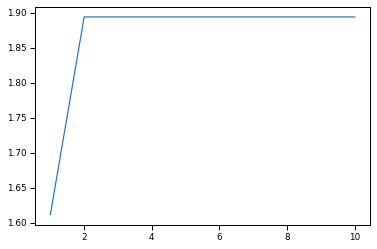

In [50]:
ax = sns.lineplot(x=nb_init, y=mutual_info_score)

# evaluate model

In [60]:
%%time
m=final
score_model(m=m, m_full=m_full, x=x_test)

NameError: name 'x_test' is not defined

## Prediction and quantile computation

In [64]:
%%time
ds = predict(m=m, x=x, var_name_ds=var_name_ds, var_predict = var_name_ds + "_scaled_reduced", k=k)

CPU times: user 27.3 s, sys: 7.6 s, total: 34.9 s
Wall time: 8.41 s


## Plots

plot finished in 13.486126184463501sec
exec time saved
CPU times: user 5.44 s, sys: 5.34 s, total: 10.8 s
Wall time: 13.5 s


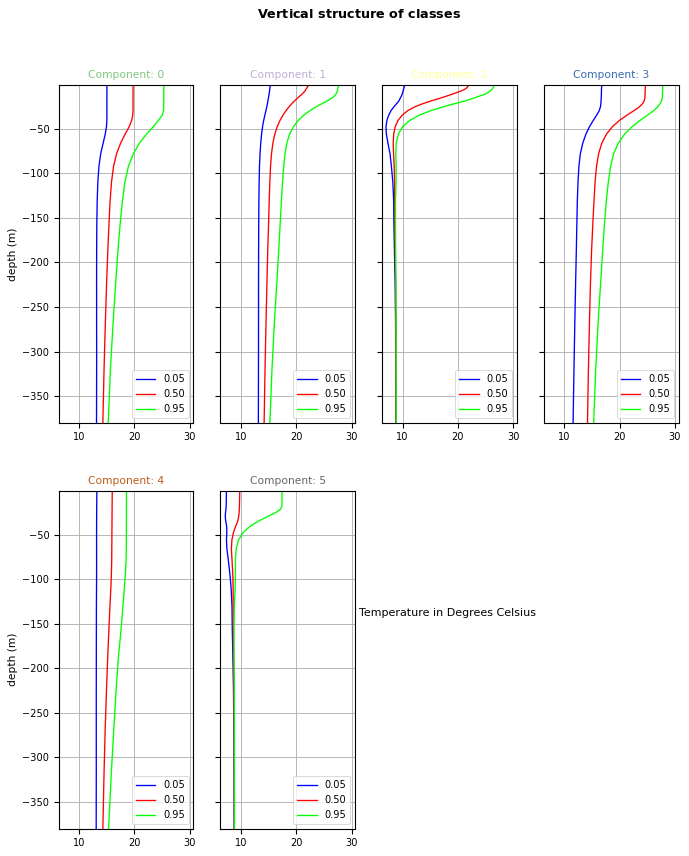

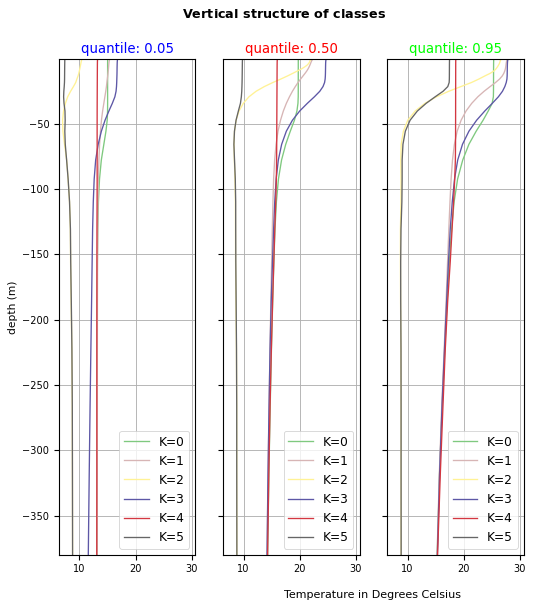

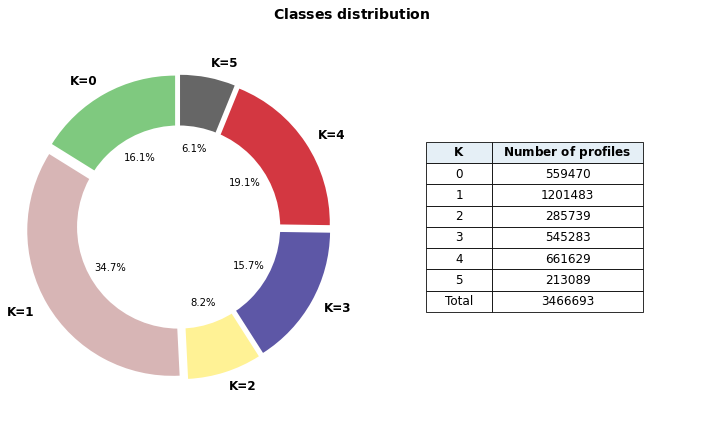

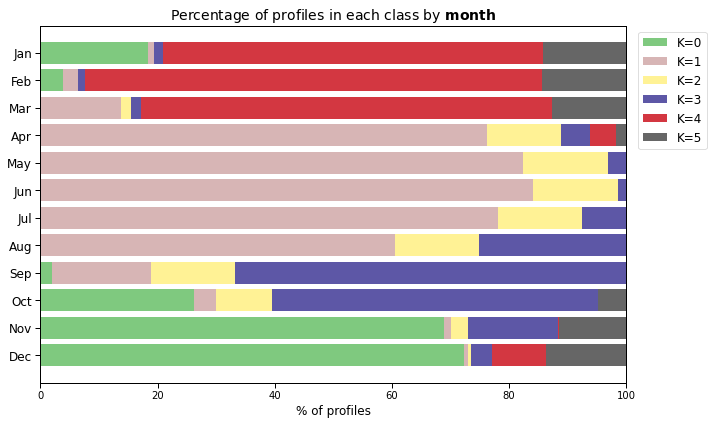

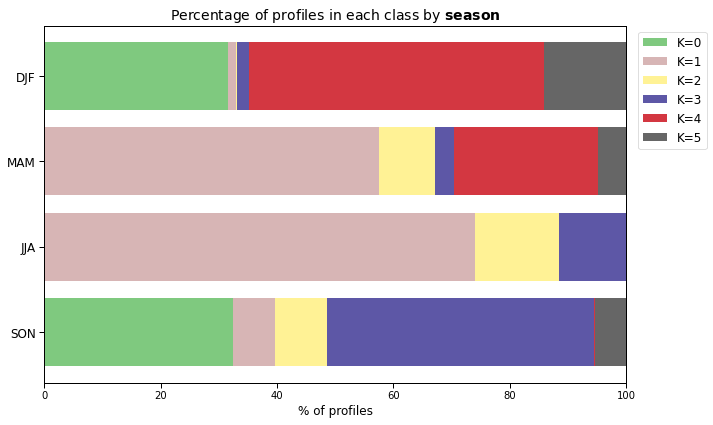

In [66]:
%%time
# name_ext = '_trainsize' + str(train_size)
# name_ext = '_full2'
start_time = time.time()
generate_plots(ds=ds, var_name_ds=var_name_ds, k=k, algorithm=algorithm)
plot_time = time.time() - start_time
print("plot finished in " + str(plot_time) + "sec")
# tmp_log = {
#     'ncpu': 8,
#     'ram': 16,
#     'platform': "local",
#     'time_load': load_time,
#     'time_train': train_time,
#     'time_prediction': prediction_time,
#     'time_plot': plot_time,
#     'total_time': load_time + train_time + prediction_time + plot_time,
#     'file_size': (ds.nbytes / 1073741824),
# }
# print(tmp_log)
print("exec time saved")

In [13]:
%load_ext line_profiler

Figure saved in ./GMM_scaling_out/vertical_strucbatch.png
Figure saved in ./GMM_scaling_out/vertical_struc_compbatch.png
Figure saved in ./GMM_scaling_out/spatial_distr_freqbatch.png
Figure saved in ./GMM_scaling_out/pie_chartbatch.png
Figure saved in temporal_distr_months.png
Figure saved in temporal_distr_season.png


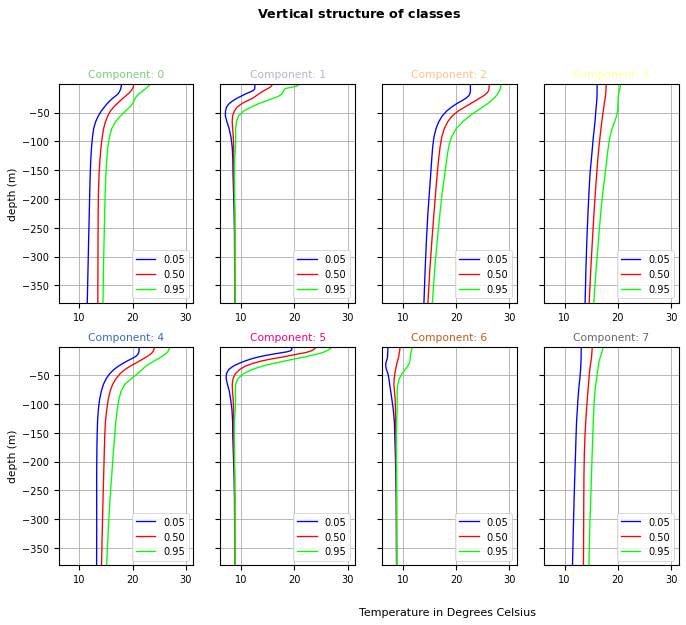

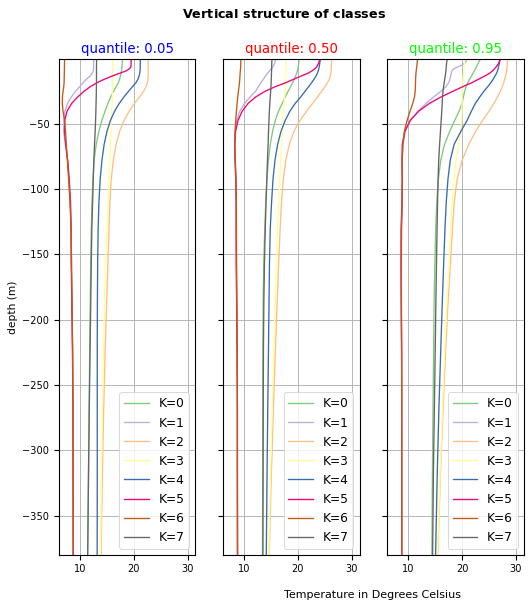

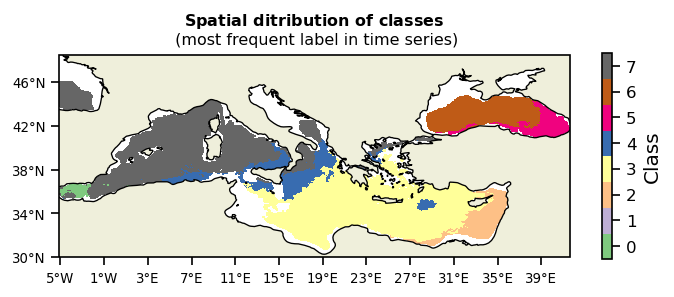

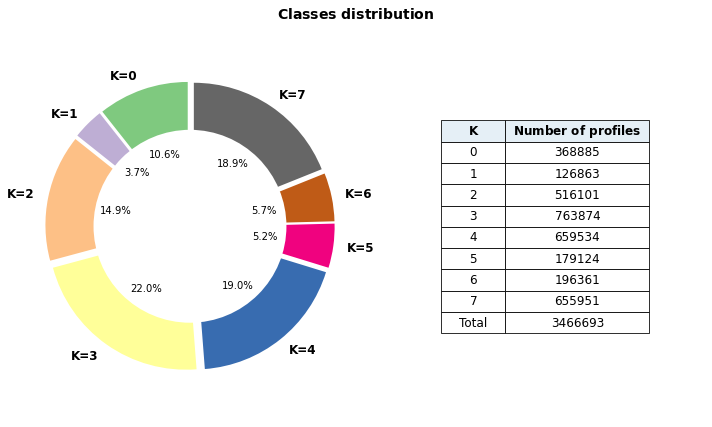

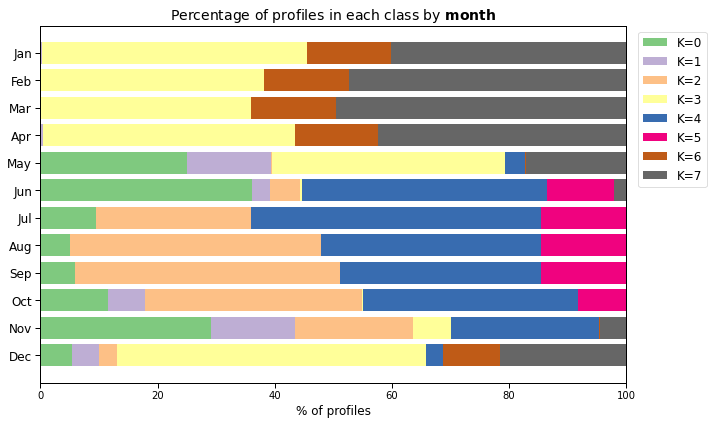

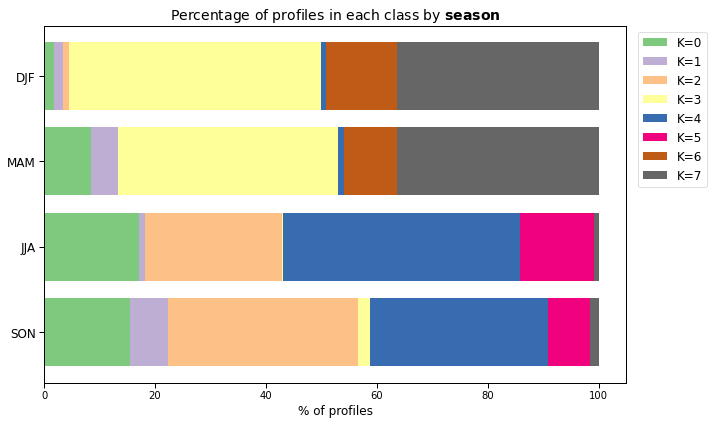

Timer unit: 1e-06 s

Total time: 47.5612 s
File: /home1/datahome/lbachelo/Documents/speed_test/preprocessing_utils.py
Function: generate_plots at line 111

Line #      Hits         Time  Per Hit   % Time  Line Contents
   111                                           def generate_plots(ds, var_name_ds, k, algorithm):
   112                                               """
   113                                               Generates and saves the following plots:
   114                                               - vertical structure: vertical structure of each classes. It draws the mean profile and the 0.05 and 0.95 quantiles
   115                                               - vertical structure comp: vertical structure graph but Quantiles are being plotted together to highlight
   116                                               differences between classes.
   117                                               - Spacial distribution: plot the PCM labels in a map to analyse the

In [14]:
%lprun -f generate_plots generate_plots(ds=ds, var_name_ds=var_name_ds, k=k, algorithm=algorithm)